In [1]:
# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

from scipy.stats import pearsonr, spearmanr, norminvgauss, invgauss, expon, entropy, lognorm, norm, gamma
from sklearn.model_selection import StratifiedKFold
import anndata as ad

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from tqdm import tqdm
import copy
import pickle 
from multiprocessing import Pool

from utils import *

In [2]:
plt.rcParams['font.size'] = '16'
plt.rcParams['lines.linewidth'] = 6
plt.rcParams['lines.markersize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
label_font = '20'
legend_font = '16'
title_font = '24'

color_palette = ["#e07a5f","#3d405b","#81b29a","#f2cc8f","#98c1d9","#457b9d","#c74546","#613f75"]
gray = '#8b96ad'
red = '#c74546'
dark = 'k'

from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(color_palette))

# Load data and QC

In [3]:
alldata = ad.read_h5ad('/home/mffang/data/counts/10x/hgmm_3pv3_2021_10k_controller/all/counts_filtered/adata.h5ad')
alldata

AnnData object with n_obs × n_vars = 10492 × 73868
    layers: 'ambiguous', 'mature', 'nascent'

In [4]:
for i,gene in enumerate(alldata.var_names):
    if gene[3] == 'M':
        print(i)
        break

39583


In [5]:
adata = alldata.copy()
adata.X = adata.layers['nascent'] + adata.layers['mature'] + adata.layers['ambiguous']
adata.layers['unspliced'] = adata.layers['nascent'] 
adata.layers['spliced'] = adata.layers['mature'] + adata.layers['ambiguous']
adata

AnnData object with n_obs × n_vars = 10492 × 73868
    layers: 'ambiguous', 'mature', 'nascent', 'unspliced', 'spliced'

In [6]:
adata.var['gene_id'] = adata.var_names
adata.var_names = [g.split('.')[0] for g in adata.var_names]
adata.var

,gene_id
ENSG00000228037,ENSG00000228037.1
ENSG00000142611,ENSG00000142611.17
ENSG00000284616,ENSG00000284616.1
ENSG00000157911,ENSG00000157911.11
ENSG00000260972,ENSG00000260972.1
...,...
ENSMUSG00000094799,ENSMUSG00000094799.2
ENSMUSG00000095019,ENSMUSG00000095019.2
ENSMUSG00000094915,ENSMUSG00000094915.2
ENSMUSG00000079808,ENSMUSG00000079808.4


In [7]:
adata.X = adata.layers['nascent'] + adata.layers['mature'] + adata.layers['ambiguous']
rna = adata[:,:39583].copy()
mtx1 = rna.X.toarray() 

rna = adata[:,39583:].copy()
mtx2 = rna.X.toarray() 

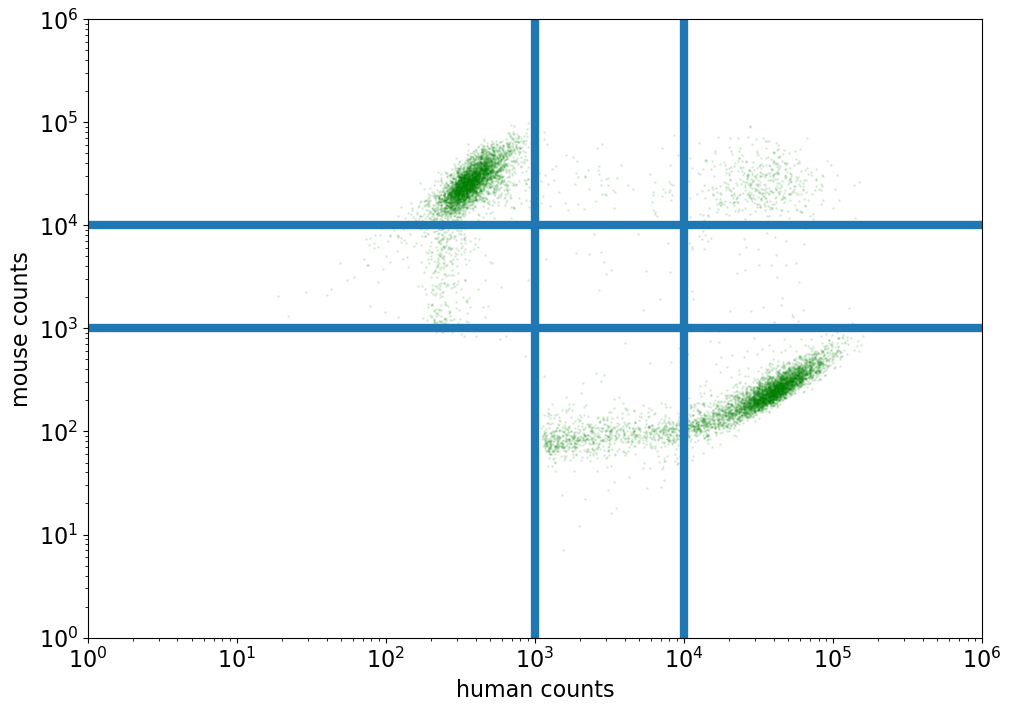

In [8]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(np.asarray(mtx1.sum(axis=1)), np.asarray(mtx2.sum(axis=1)), color="green", alpha=0.1, s=1)
ax.set_xlabel("human counts")
ax.set_ylabel("mouse counts")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim((1,1e6))
ax.set_ylim((1,1e6))

ax.axhline(y=10000)
ax.axhline(y=1000)
ax.axvline(x=10000)
ax.axvline(x=1000)

plt.show()

In [9]:
human = adata[(mtx1.sum(axis=1)>10000) & (mtx2.sum(axis=1)<1000)]
mouse = adata[(mtx1.sum(axis=1)<1000) & (mtx2.sum(axis=1)>10000)]
doublet = adata[(mtx1.sum(axis=1)>10000) & (mtx2.sum(axis=1)>10000)]

In [10]:
human_human = human[:,:39583]
mouse_human = mouse[:,:39583]
human_mouse = human[:,39583:]
mouse_mouse = mouse[:,39583:]
doublet_human = doublet[:,:39583]
doublet_mouse = doublet[:,39583:]

Text(0.02, 0.5, 'Human cell means')

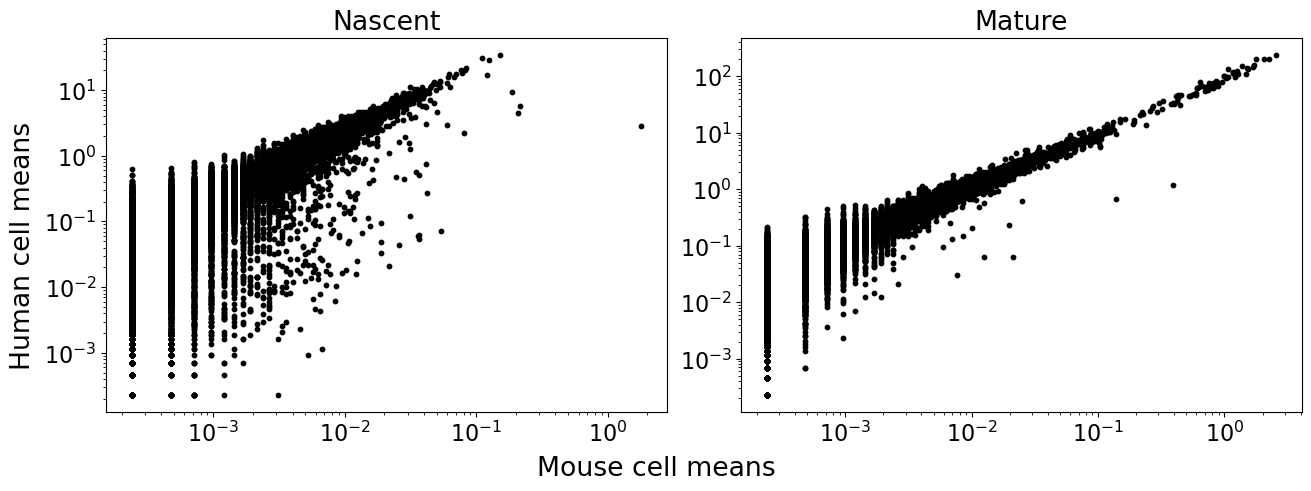

In [11]:
fig, ax = plt.subplots(1,2,figsize=(13,4.8))
ax[0].scatter(mouse_human.layers['nascent'].toarray().mean(0),human_human.layers['nascent'].toarray().mean(0),s=10,color='k')
#ax[0].plot(mouse_human.layers['nascent'].toarray().mean(0),100*mouse_human.layers['nascent'].toarray().mean(0),zorder=0,color='lightgray')
#ax[0].plot(mouse_human.layers['nascent'].toarray().mean(0),mouse_human.layers['nascent'].toarray().mean(0),zorder=0,color='lightblue')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Nascent')
ax[1].scatter(mouse_human.layers['mature'].toarray().mean(0),human_human.layers['mature'].toarray().mean(0),s=10,color='k')
#ax[1].plot(mouse_human.layers['mature'].toarray().mean(0),100*mouse_human.layers['mature'].toarray().mean(0),zorder=0,color='lightgray')
#ax[1].plot(mouse_human.layers['mature'].toarray().mean(0),mouse_human.layers['mature'].toarray().mean(0),zorder=0,color='lightblue')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('Mature')
#ax[2].scatter(mouse_human.layers['ambiguous'].toarray().mean(0),human_human.layers['ambiguous'].toarray().mean(0),s=10,color='k')
#ax[2].plot(mouse_human.layers['ambiguous'].toarray().mean(0),100*mouse_human.layers['ambiguous'].toarray().mean(0),zorder=0,color='lightgray')
#ax[2].plot(mouse_human.layers['ambiguous'].toarray().mean(0),mouse_human.layers['ambiguous'].toarray().mean(0),zorder=0,color='lightblue')
#ax[2].set_xscale('log')
#ax[2].set_yscale('log')
#ax[2].set_title('Ambiguous')
fig.supxlabel('Mouse cell means')
fig.supylabel('Human cell means')
#fig.suptitle('Human genes')

Text(0.02, 0.5, 'Mouse cell means')

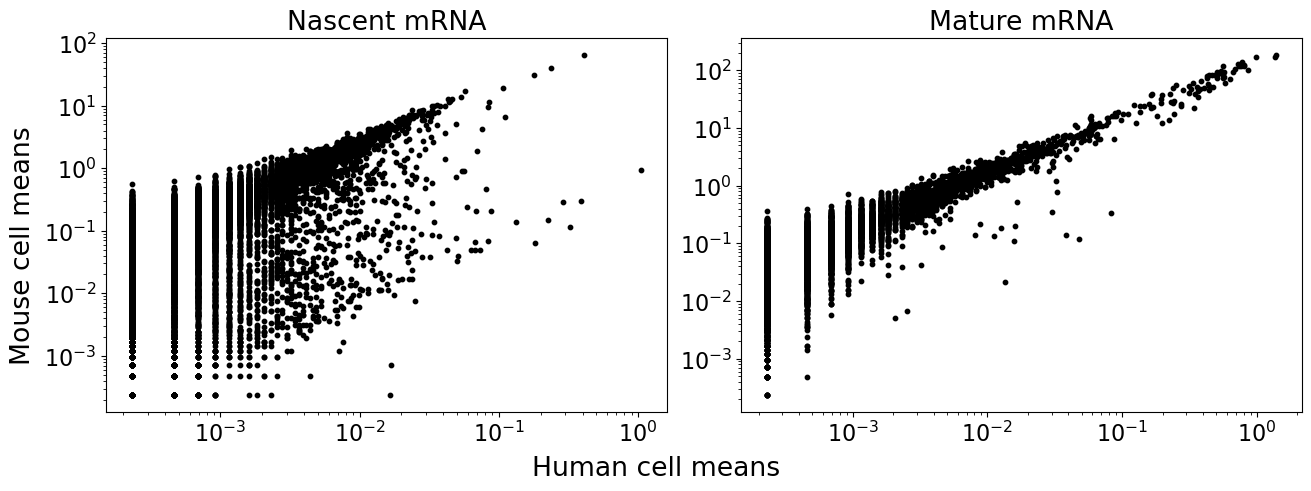

In [12]:
fig, ax = plt.subplots(1,2,figsize=(13,4.8))
ax[0].scatter(human_mouse.layers['nascent'].toarray().mean(0),mouse_mouse.layers['nascent'].toarray().mean(0),s=10,color='k')
#ax[0].plot(human_mouse.layers['nascent'].toarray().mean(0),200*human_mouse.layers['nascent'].toarray().mean(0),zorder=0,color='lightgray')
#ax[0].plot(human_mouse.layers['nascent'].toarray().mean(0),human_mouse.layers['nascent'].toarray().mean(0),zorder=0,color='lightblue')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Nascent mRNA')
ax[1].scatter(human_mouse.layers['mature'].toarray().mean(0),mouse_mouse.layers['mature'].toarray().mean(0),s=10,color='k')
#ax[1].plot(human_mouse.layers['mature'].toarray().mean(0),200*human_mouse.layers['mature'].toarray().mean(0),zorder=0,color='lightgray')
#ax[1].plot(human_mouse.layers['mature'].toarray().mean(0),human_mouse.layers['mature'].toarray().mean(0),zorder=0,color='lightblue')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('Mature mRNA')
#ax[2].scatter(human_mouse.layers['ambiguous'].toarray().mean(0),mouse_mouse.layers['ambiguous'].toarray().mean(0),s=10,color='k')
#ax[2].plot(human_mouse.layers['ambiguous'].toarray().mean(0),200*human_mouse.layers['ambiguous'].toarray().mean(0),zorder=0,color='lightgray')
#ax[2].plot(human_mouse.layers['ambiguous'].toarray().mean(0),human_mouse.layers['ambiguous'].toarray().mean(0),zorder=0,color='lightblue')
#ax[2].set_xscale('log')
#ax[2].set_yscale('log')
#ax[2].set_title('ambiguous')
fig.supxlabel('Human cell means')
fig.supylabel('Mouse cell means')
#fig.suptitle('Mouse genes')

# Human cells

In [13]:
adata = human_human.copy()
ERCC = human_mouse.copy()

0.23930451 0.23660825 0.5515918


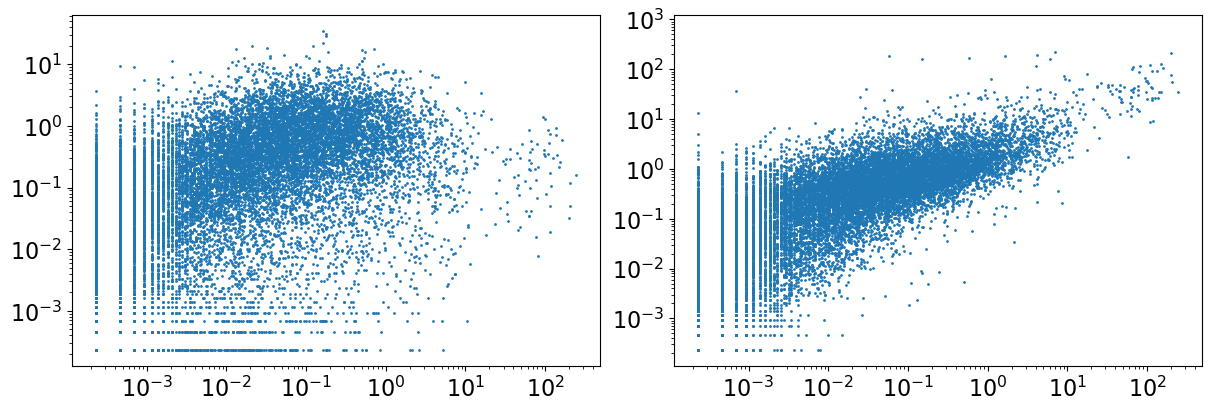

In [14]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['mature'].toarray().mean(0),adata.layers['nascent'].toarray().mean(0),s=1)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].scatter(adata.layers['mature'].toarray().mean(0),adata.layers['ambiguous'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
print(adata.layers['nascent'].toarray().mean(),adata.layers['mature'].toarray().mean(),adata.layers['ambiguous'].toarray().mean())

## Normalized covariance between all genes

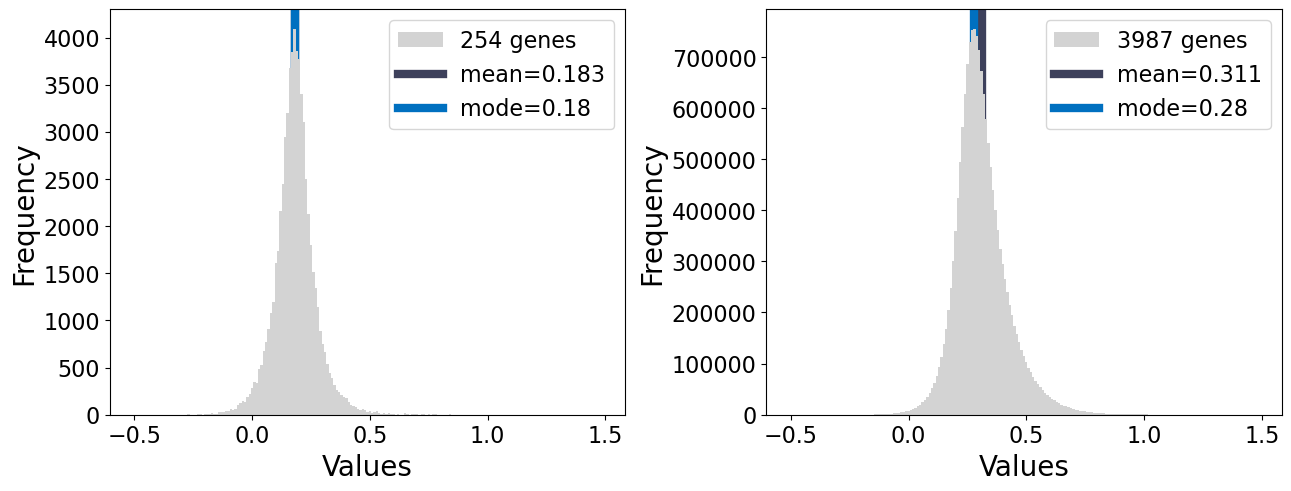

In [15]:
fig,axs = plt.subplots(1,2,figsize=(12.8,4.8))

s = estimate_s(N1=ERCC.X.toarray(),ax=axs[0],min_mean=0.1)
s = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs[1],min_mean=0.1)

for i in range(len(axs)):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

## Select Poisson genes

In [16]:
X_ = ERCC.X.toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)
E_lower_bound, E_upper_bound, E_eta_bootstrap = bootstrapping_func(normalized_variance,[X_],B=1000,n_cores=50)

s = 0.18
E_Pgene_mask = (s < E_upper_bound) & (s > E_lower_bound) 
E_Pgene = human_mouse.var_names[nonzero_idx][E_Pgene_mask]

X_ = adata.layers["mature"].toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)
lower_bound, upper_bound, eta_bootstrap = bootstrapping_func(normalized_variance,[X_],B=1000,n_cores=50)

s = 0.28
S_Pgene_mask = (s < upper_bound) & (s > lower_bound) 
S_Pgene = adata.var_names[nonzero_idx][S_Pgene_mask]

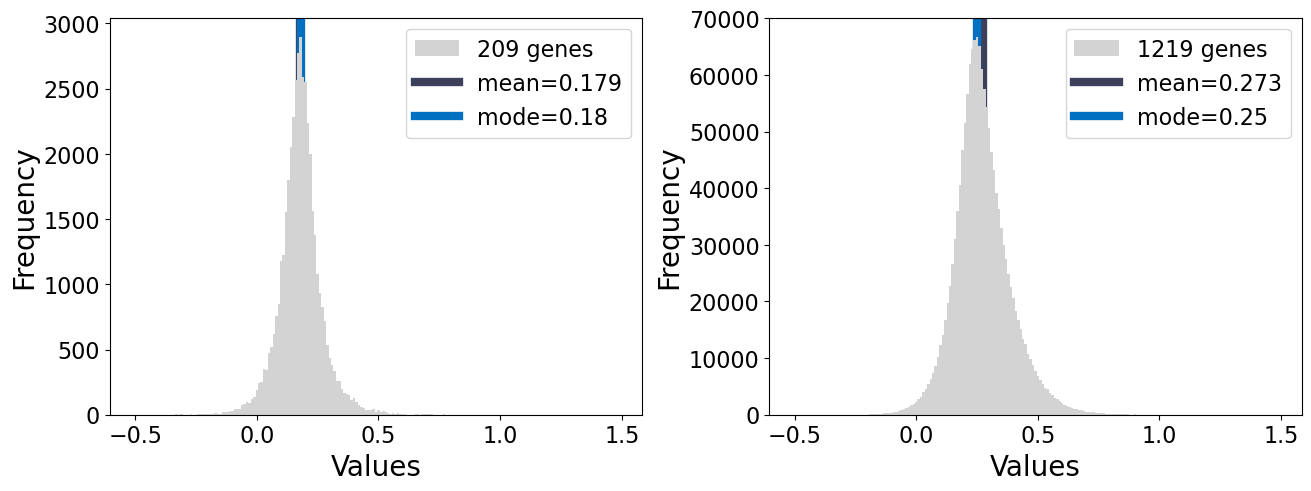

In [17]:
fig,axs = plt.subplots(1,2,figsize=(13,4.8))

X_ = ERCC.X.toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
Pgene_mask = E_Pgene_mask.copy()
_ = estimate_s(X_[:,Pgene_mask],ax=axs[0])

X_ = adata.layers["mature"].toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
Pgene_mask = S_Pgene_mask.copy()
_ = estimate_s(X_[:,Pgene_mask],ax=axs[1])

for i in range(2):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

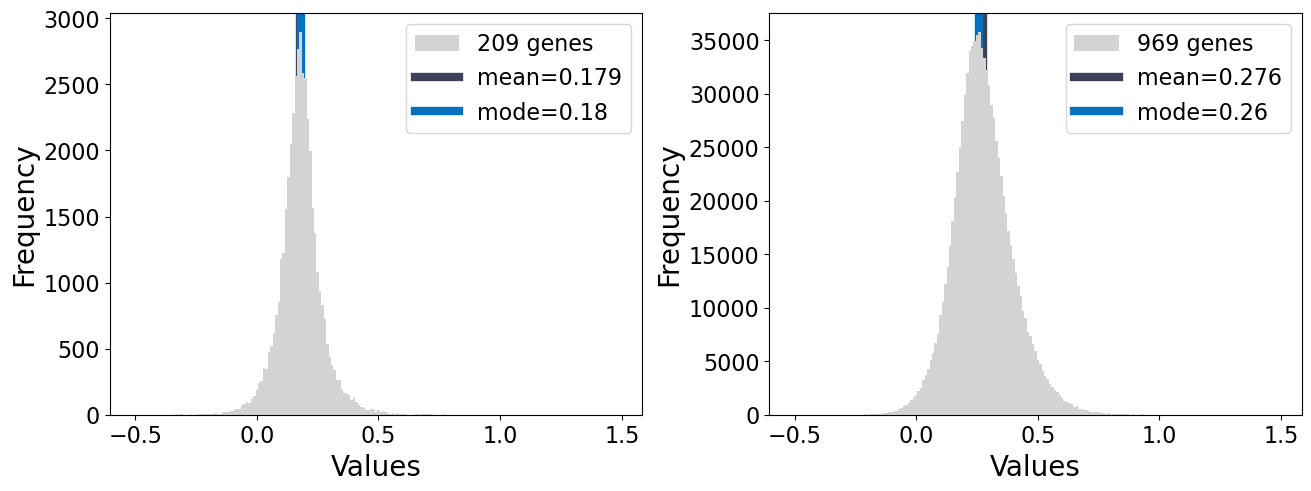

In [18]:
fig,axs = plt.subplots(1,2,figsize=(13,4.8))

X_ = ERCC.X.toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
Pgene_mask = E_Pgene_mask.copy()
_ = estimate_s(X_[:,Pgene_mask],ax=axs[0])

X_ = adata.layers["mature"].toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]

s = 0.25
S_Pgene_mask = (s < upper_bound) & (s > lower_bound) 
S_Pgene = adata.var_names[nonzero_idx][S_Pgene_mask]
Pgene_mask = S_Pgene_mask.copy()
_ = estimate_s(X_[:,Pgene_mask],ax=axs[1])

for i in range(2):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

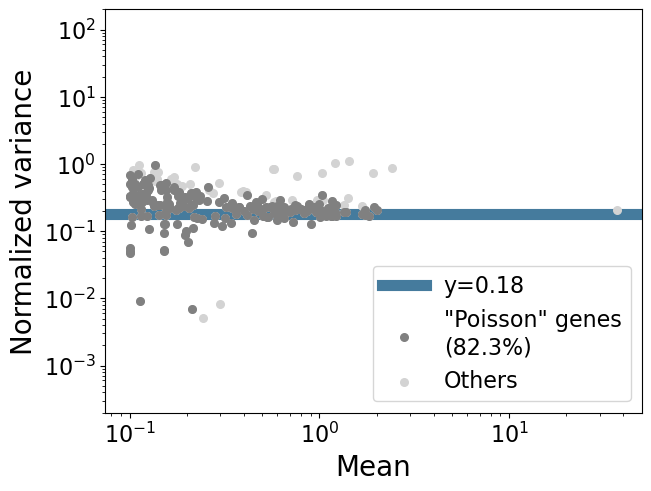

In [19]:
s = 0.18
X_ = ERCC.X.toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)
Pgene_mask = E_Pgene_mask.copy()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.axhline(y=s, linestyle='-', color='#457b9d', linewidth=8, zorder=0, label="y="+str(np.around(s,3)))
ax.scatter(X_mean[Pgene_mask], (X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]**2, s=30, alpha=1, zorder=2, c='gray', \
           label='"Poisson" genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, (X_var-X_mean)/X_mean**2,c='lightgray',alpha=1, s=30, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([2e-4,2e2])
ax.set_xlabel('Mean',fontsize=20);
ax.set_ylabel('Normalized variance',fontsize=20);
ax.legend(loc='lower right',fontsize=16);

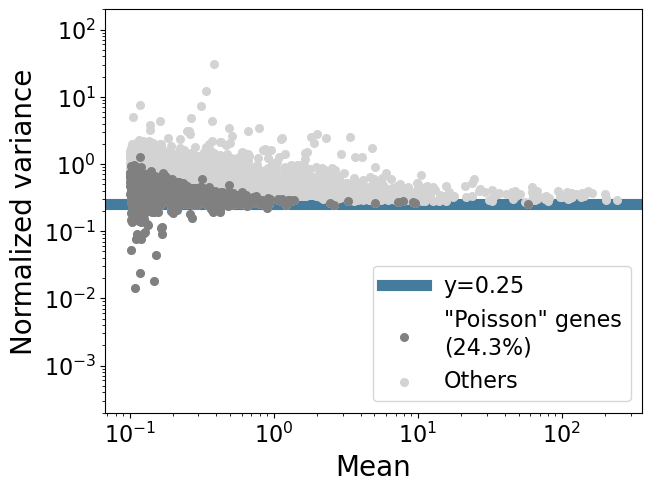

In [20]:
s = 0.25
X_ = adata.layers["mature"].toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)
Pgene_mask = S_Pgene_mask.copy()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.axhline(y=s, linestyle='-', color='#457b9d', linewidth=8, zorder=0, label="y="+str(np.around(s,3)))
ax.scatter(X_mean[Pgene_mask], (X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]**2, s=30, alpha=1, zorder=2, c='gray', \
           label='"Poisson" genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, (X_var-X_mean)/X_mean**2,c='lightgray',alpha=1, s=30, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([2e-4,2e2])
ax.set_xlabel('Mean',fontsize=20);
ax.set_ylabel('Normalized variance',fontsize=20);
ax.legend(loc='lower right',fontsize=16);

In [21]:
np.savetxt('results/hgmm_2021_controller_human_Pgenes.txt', S_Pgene, fmt='%s')
len(S_Pgene)

969

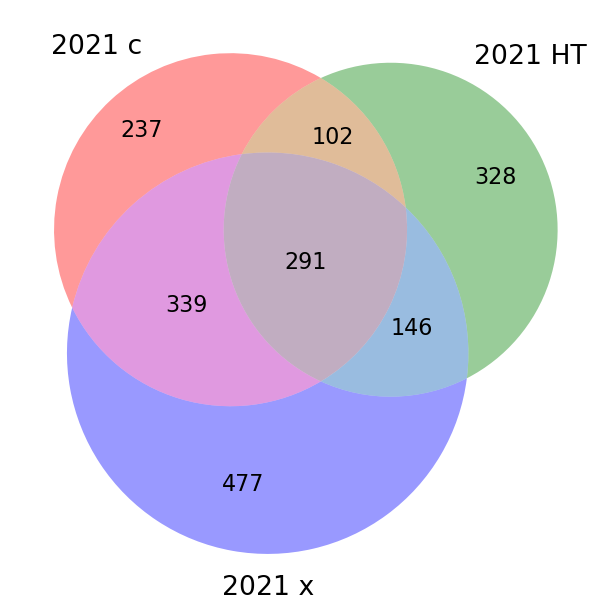

In [29]:
from matplotlib_venn import venn3

other_Pgenes = np.loadtxt("results/hgmm_2021_HT_human_Pgenes.txt", dtype=str)
other_Pgenes_2 = np.loadtxt("results/hgmm_2021_x_human_Pgenes.txt", dtype=str)

# Convert to sets for Venn diagram
S_Pgene_set = set(S_Pgene)
other_Pgenes_set = set(other_Pgenes)
other_Pgenes_set_2 = set(other_Pgenes_2)

# Plot Venn diagram
plt.figure(figsize=(6,6))
venn3([S_Pgene_set, other_Pgenes_set,other_Pgenes_set_2], set_labels=('2021 c','2021 HT', '2021 x'))

# Show the plot
plt.show()

# Mouse cells

In [46]:
adata = mouse_mouse.copy()
ERCC = mouse_human.copy()

0.11963381 0.21073514 0.49515826


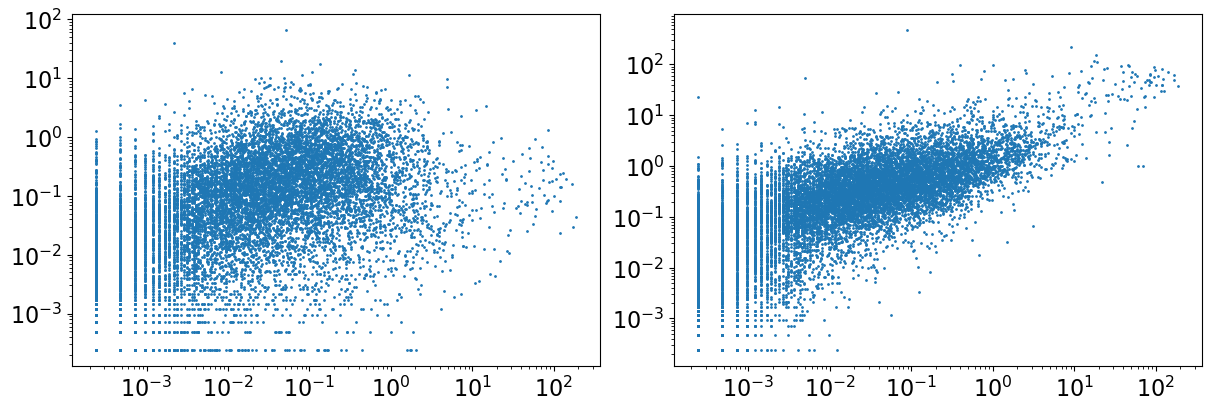

In [31]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['mature'].toarray().mean(0),adata.layers['nascent'].toarray().mean(0),s=1)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].scatter(adata.layers['mature'].toarray().mean(0),adata.layers['ambiguous'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
print(adata.layers['nascent'].toarray().mean(),adata.layers['mature'].toarray().mean(),adata.layers['ambiguous'].toarray().mean())

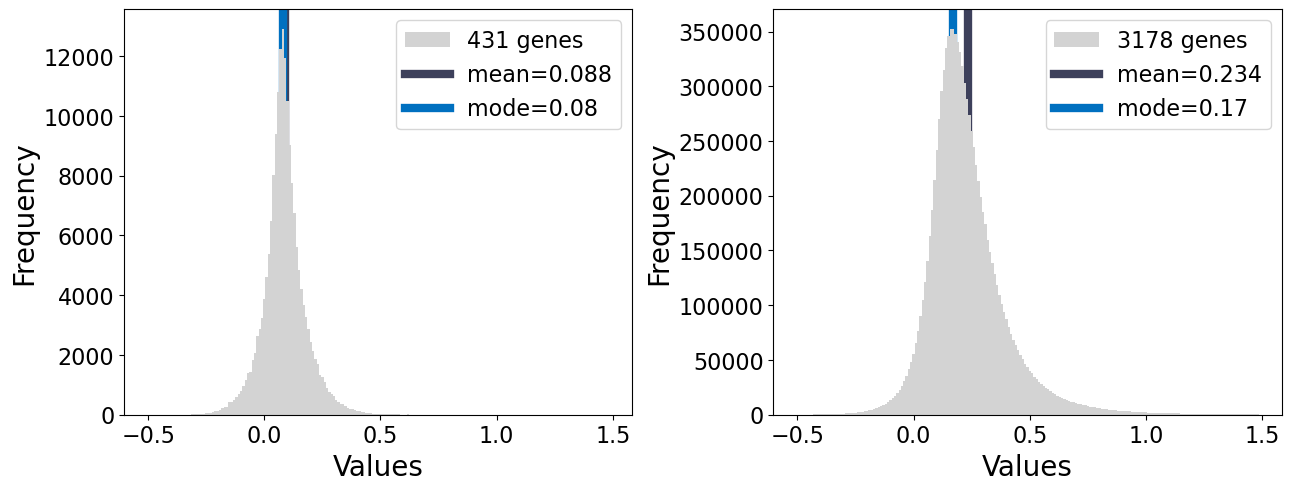

In [47]:
fig,axs = plt.subplots(1,2,figsize=(12.8,4.8))

s = estimate_s(N1=ERCC.X.toarray(),ax=axs[0],min_mean=0.1)
s_mm = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs[1])

for i in range(2):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

In [48]:
s = 0.08
X_ = ERCC.X.toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)
E_lower_bound, E_upper_bound, E_eta_bootstrap = bootstrapping_func(normalized_variance,[X_],B=1000,n_cores=50)
E_Pgene_mask = (s < E_upper_bound) & (s > E_lower_bound) 
E_Pgene = ERCC.var_names[nonzero_idx][E_Pgene_mask]

X_ = adata.layers["mature"].toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)
lower_bound, upper_bound, eta_bootstrap = bootstrapping_func(normalized_variance,[X_],B=1000,n_cores=50)

s = 0.17
S_Pgene_mask = (s < upper_bound) & (s > lower_bound) 
S_Pgene = adata.var_names[nonzero_idx][S_Pgene_mask]

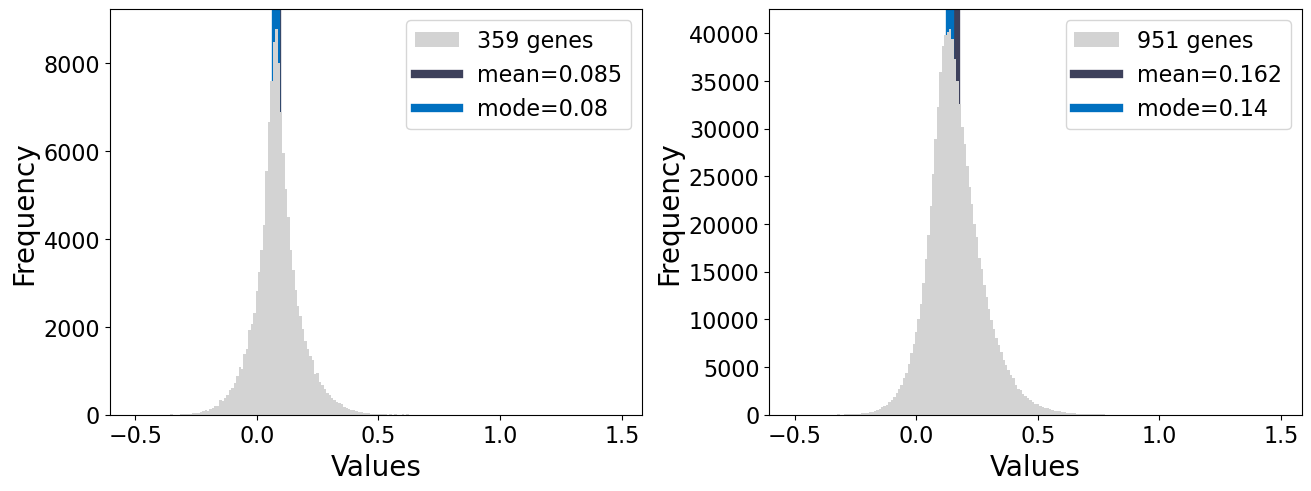

In [49]:
fig,axs = plt.subplots(1,2,figsize=(13,4.8))

X_ = ERCC.X.toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
Pgene_mask = E_Pgene_mask.copy()
s = estimate_s(X_[:,Pgene_mask],ax=axs[0],min_mean=0.1)

X_ = adata.layers["mature"].toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
Pgene_mask = S_Pgene_mask.copy()
s = estimate_s(X_[:,Pgene_mask],ax=axs[1],min_mean=0.1)

for i in range(2):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

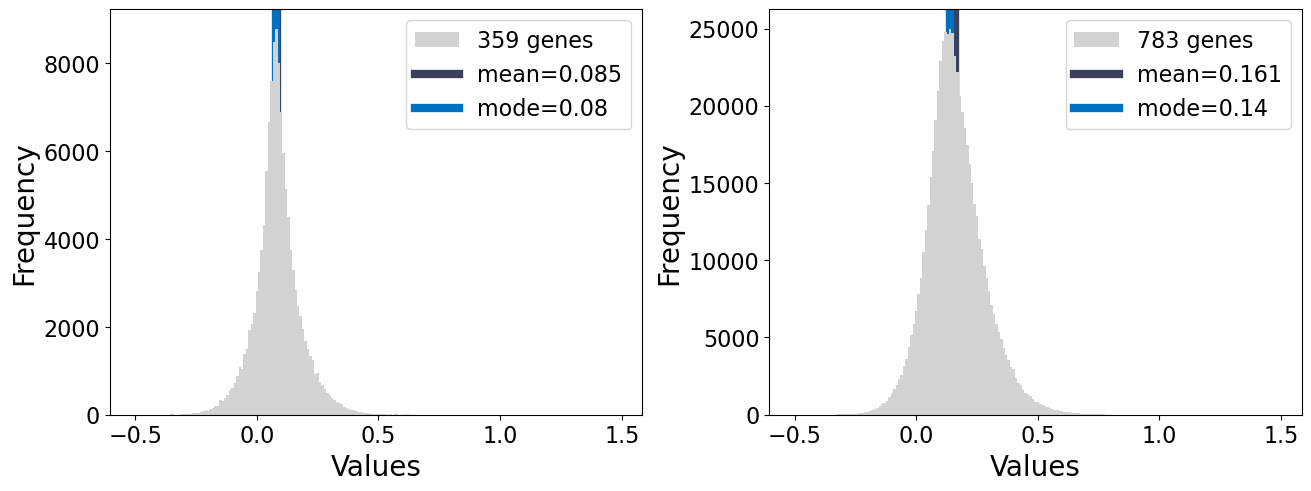

In [50]:
fig,axs = plt.subplots(1,2,figsize=(13,4.8))

X_ = ERCC.X.toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
Pgene_mask = E_Pgene_mask.copy()
_ = estimate_s(X_[:,Pgene_mask],ax=axs[0])

X_ = adata.layers["mature"].toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]

s = 0.14
S_Pgene_mask = (s < upper_bound) & (s > lower_bound) 
S_Pgene = adata.var_names[nonzero_idx][S_Pgene_mask]
Pgene_mask = S_Pgene_mask.copy()
_ = estimate_s(X_[:,Pgene_mask],ax=axs[1])

for i in range(2):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

In [38]:
X_ = adata.layers["mature"].toarray()
nonzero_idx = X_.mean(0)>0.1
S_Pgenes = adata.var_names[nonzero_idx][S_Pgene_mask]
np.savetxt('results/hgmm_2021_controller_mouse_Pgenes.txt', S_Pgenes, fmt='%s')
len(S_Pgenes)

783

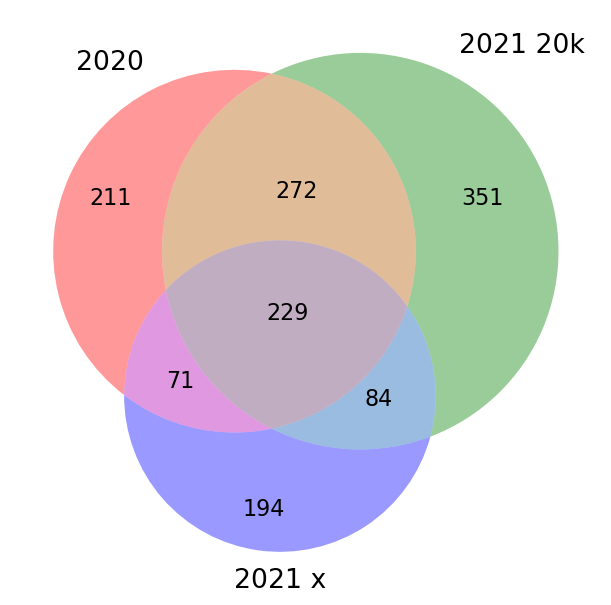

In [43]:
from matplotlib_venn import venn3

other_Pgenes = np.loadtxt("results/hgmm_2021_x_mouse_Pgenes.txt", dtype=str)
other_Pgenes_2 = np.loadtxt("results/hgmm_2021_HT_mouse_Pgenes.txt", dtype=str)

# Convert to sets for Venn diagram
S_Pgene_set = set(S_Pgene)
other_Pgenes_set = set(other_Pgenes)
other_Pgenes_set_2 = set(other_Pgenes_2)

# Plot Venn diagram
plt.figure(figsize=(6,6))
venn3([S_Pgene_set, other_Pgenes_set,other_Pgenes_set_2], set_labels=('2020','2021 20k', '2021 x'))

# Show the plot
plt.show()

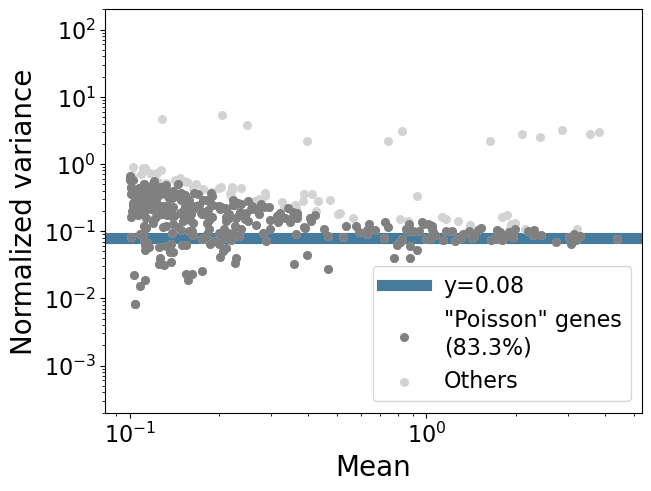

In [44]:
s = 0.08
X_ = ERCC.X.toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)
Pgene_mask = E_Pgene_mask.copy()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.axhline(y=s, linestyle='-', color='#457b9d', linewidth=8, zorder=0, label="y="+str(np.around(s,3)))
ax.scatter(X_mean[Pgene_mask], (X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]**2, s=30, alpha=1, zorder=2, c='gray', \
           label='"Poisson" genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, (X_var-X_mean)/X_mean**2,c='lightgray',alpha=1, s=30, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([2e-4,2e2])
ax.set_xlabel('Mean',fontsize=20);
ax.set_ylabel('Normalized variance',fontsize=20);
ax.legend(loc='lower right',fontsize=16);

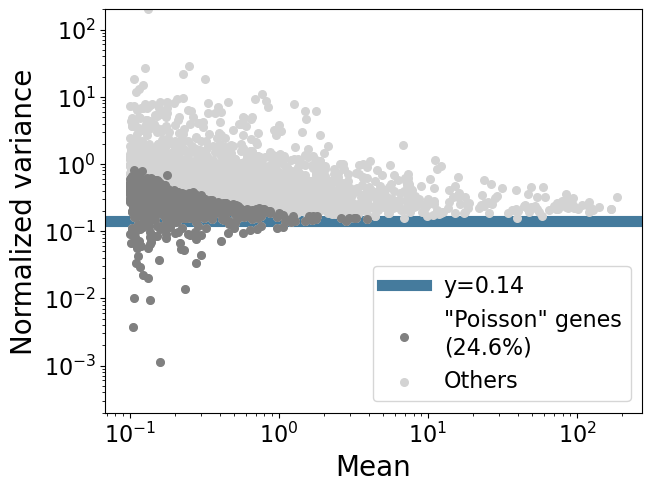

In [45]:
s = 0.14

X_ = adata.layers['mature'].toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)
Pgene_mask = S_Pgene_mask.copy()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.axhline(y=s, linestyle='-', color='#457b9d', linewidth=8, zorder=0, label="y="+str(np.around(s,3)))
ax.scatter(X_mean[Pgene_mask], (X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]**2, s=30, alpha=1, zorder=2, c='gray', \
           label='"Poisson" genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, (X_var-X_mean)/X_mean**2,c='lightgray',alpha=1, s=30, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([2e-4,2e2])
ax.set_xlabel('Mean',fontsize=20);
ax.set_ylabel('Normalized variance',fontsize=20);
ax.legend(loc='lower right',fontsize=16);